# Readme
1. Import Libraries and upload files, including elevation dataset: https://www.fisheries.noaa.gov/inport/item/73908
2. Subset dataset
3. Convert coordinates into lat and lon system (EPSG:4326)
4. Filter for region of interest
5. Match elevation data to upland forest coordinates
6. Make pie chart to show category distribution
7. Calculate average elevations
8. ANOVA statistical analysis with Tukey test
9. Make Box plot with showing means 

## 1. Import Libraries

In [1]:
import zipfile
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt
import xarray as xr
from pyproj import Transformer
from shapely.ops import transform
from shapely.geometry import Point
import numpy as np
from geopandas import GeoSeries
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pyproj import Transformer
from shapely.ops import transform
import csv 
import pandas as pd
import os
import seaborn as sns
import geopandas
import numpy as np
from scipy import stats
from matplotlib.lines import Line2D
import rioxarray

### Upload files by category

In [2]:
abrupt = '/home/jovyan/sara_typrin/ndvi_landsat/data/forest_pathway_df/abrupt_df.csv'
gradual = '/home/jovyan/sara_typrin/ndvi_landsat/data/forest_pathway_df/gradual_df.csv'
recovery = '/home/jovyan/sara_typrin/ndvi_landsat/data/forest_pathway_df/recovery_df.csv'
stable = '/home/jovyan/sara_typrin/ndvi_landsat/data/forest_pathway_df/stable_df.csv'

# Read each CSV into a list of DataFrames
abrupt = pd.read_csv(abrupt) 
gradual = pd.read_csv(gradual) 
recovery = pd.read_csv(recovery)
stable = pd.read_csv(stable)

### Open elevation tif file as xarray:

In [3]:
da = rioxarray.open_rasterio('/home/jovyan/sara_typrin/elevation/2022_ngs_ches_bay_topobathy_DEM_J1221339tR0_C0.tif', masked=True)
print("coordinate system is" , da.rio.crs)

coordinate system is EPSG:6488


## 2. Subsetting

Note: Due to the high vlume of datapoints, can only subset around 12000 points at a time. The commented out subset_da are other possibilities for where to subset

In [4]:
# subset_da = da.isel(y=slice(18000, 20000), x=slice(18000, 20000))
# subset_da = da.isel(y=slice(12000, 18000), x=slice(12000, 18000))
# subset_da = da.isel(y=slice(10000, 20000), x=slice(10000, 20000))
subset_da = da.isel(y=slice(0, 12000), x=slice(0, 12000))
# subset.values
# subset_da

We do not want Nan values. dropna() only works on a one dimensional list so we need to stack subset+da into one dimension, called 'points'

In [5]:
stacked = subset_da.stack(points = ('x', 'y', 'band'))
non_nan_stacked = stacked.dropna(dim='points')

In [6]:
da = non_nan_stacked
print("elevation values are", da.values)

elevation values are [-16.586046  -16.614954  -16.450016  ...   2.359286    2.3797374
   2.2698572]


# 3. Coordinate Transformation

### Convert coordinates from ESPG 6488 to ESPG 4326

In [8]:
# x and y coordinates from the DataArray
x = da['x'].values  # shape (nx,)
y = da['y'].values  # shape (ny,)

# Create transformer: from EPSG:6488 (UTM w/ height) to EPSG:4326 (lat/lon)
transformer = Transformer.from_crs("EPSG:6488", "EPSG:4326", always_xy=True)

# Transform 1D x to longitude using mean y
y_dummy = np.full_like(x, y.mean())
lon_x, _ = transformer.transform(x, y_dummy)

# Transform 1D y to latitude using mean x
x_dummy = np.full_like(y, x.mean())
_, lat_y = transformer.transform(x_dummy, y)

# Check results
print("Latitude range:", lat_y.min(), lat_y.max())
print("Longitude range:", lon_x.min(), lon_x.max())

Latitude range: 38.319151370982325 38.42603209397434
Longitude range: -76.28486248987502 -76.1475519757736


### Put converted coordinates into xarray

In [9]:
da_latlon = xr.DataArray(
    data=da.values,
    dims=["points"],
    coords={
        "lon": ("points", lon_x),
        "lat": ("points", lat_y)
    },
    name="elevation"
)
da_latlon

<xarray.DataArray 'elevation' (points: 70052781)> Size: 280MB
array([-16.586046 , -16.614954 , -16.450016 , ...,   2.359286 ,
         2.3797374,   2.2698572], dtype=float32)
Coordinates:
    lon      (points) float64 560MB -76.28 -76.28 -76.28 ... -76.15 -76.15
    lat      (points) float64 560MB 38.33 38.33 38.33 ... 38.32 38.32 38.32
Dimensions without coordinates: points

# 4. Filtering for Region of Interest

Note: This part is necessary when parts of the subset are not in region of interest

#### Check whether latitude is ascending or descending 

In [22]:
# print("Latitude first 5 values:", da_latlon.lat.values[:5])
# print("Latitude last 5 values:", da_latlon.lat.values[-5:])
print("Is latitude ascending?", np.all(np.diff(da_latlon.lat.values) > 0))

Is latitude ascending? False


#### Apply mask for region of interest bounds

In [10]:
lon_mask = (da_latlon.lon >= -76.35157) & (da_latlon.lon <= -75.68480)
lat_mask = (da_latlon.lat >= 38.19935) & (da_latlon.lat <= 38.67480)  # note: lat order (min <= lat <= max)

combined_mask = lon_mask & lat_mask

elevation_subset = da_latlon.where(combined_mask, drop=True)
#print(elevation_subset))

# 5. Coordinate matching 

### Round all lat and on values to 4 decimal places to enable coordinate matching

In [20]:
abrupt["lat"] = abrupt["lat"].round(4)
abrupt["lon"] = abrupt["lon"].round(4)

recovery["lat"] = recovery["lat"].round(4)
recovery["lon"] = recovery["lon"].round(4)

gradual["lat"] = gradual["lat"].round(4)
gradual["lon"] = gradual["lon"].round(4)

stable["lat"] = stable["lat"].round(4)
stable["lon"] = stable["lon"].round(4)

In [21]:
elevation_subset["lat"] = elevation_subset["lat"].round(4) #latitude
elevation_subset["lon"] = elevation_subset["lon"].round(4) #longitude

In [22]:
df = elevation_subset.to_dataframe(name='elevation').reset_index()
#df

### Filter out negative elevations of df because that would mean the forest is underwater, which doesn't make sense

In [24]:
df_positive = df[df["elevation"] > 0].copy()
#df_positive

### Coordinates repeat after rounding, so combine those coordinates and take their average elevations:

In [25]:
df_unique = df_positive.groupby(['lat', 'lon'], as_index=False)['elevation'].mean()
# df_unique = df.groupby(['lat', 'lon'], as_index=False)['elevation'].mean()


print(df_unique.head())

       lat      lon  elevation
0  38.3192 -76.2293   0.577499
1  38.3192 -76.2292   2.654254
2  38.3192 -76.2291   3.133291
3  38.3192 -76.2290   3.292044
4  38.3192 -76.2289   3.491620


In [35]:
# print(len(df_unique))
# print(len(df_positive))

### Convert elevation subset from a data array to dataframe

In [26]:
df_coords = pd.DataFrame({
    "lat" : df_unique.lat,
    "lon" : df_unique.lon,
    "elevation": df_unique.elevation
}).dropna()
#df_coords


In [35]:
#Confirm bounds of dataframe
# print(df_coords.lat.min())
# print(df_coords.lat.max())
# print(df_coords.lon.min())
# print(df_coords.lon.max())

38.3192
38.426
-76.2656
-76.1476


## Match category to elevation coords individually:

In [27]:
matched_abrupt = pd.merge(abrupt, df_coords, on=["lat", "lon"], how="inner")    
matched_recovery = pd.merge(recovery, df_coords, on=["lat", "lon"], how="inner")    
matched_gradual = pd.merge(gradual, df_coords, on=["lat", "lon"], how="inner")    
matched_stable = pd.merge(stable, df_coords, on=["lat", "lon"], how="inner")    

### Remove outlier (recovery point has an elevation of 17ft, which throws off data)

In [30]:
matched_recovery.elevation
np.delete(matched_recovery.elevation, 27)
recovery_list = np.delete(matched_recovery.elevation, 27)
recovery_list

array([2.2154934, 2.5930367, 2.8820648, 2.5778873, 2.2633035, 2.7685146,
       5.8557653, 3.3989382, 4.4662886, 4.1445866, 2.7141802, 9.567449 ,
       4.0903344, 3.273003 , 1.6327834, 5.5803056, 1.8227564, 2.584442 ,
       2.0839446, 2.1693163, 2.0563185, 2.2074878, 2.1266487, 2.0515454,
       3.3663466, 1.4109988, 2.3600636, 1.9917697, 2.4810386, 2.322847 ,
       2.2227848, 2.3630664, 1.9732562, 2.2116733, 2.353441 , 3.1509044,
       3.6334488, 2.4314127, 2.163055 , 2.3178778, 2.0791564, 2.2945192,
       2.0722382, 2.8845286, 2.6179066], dtype=float32)

# 6. Pie Chart Distribution 

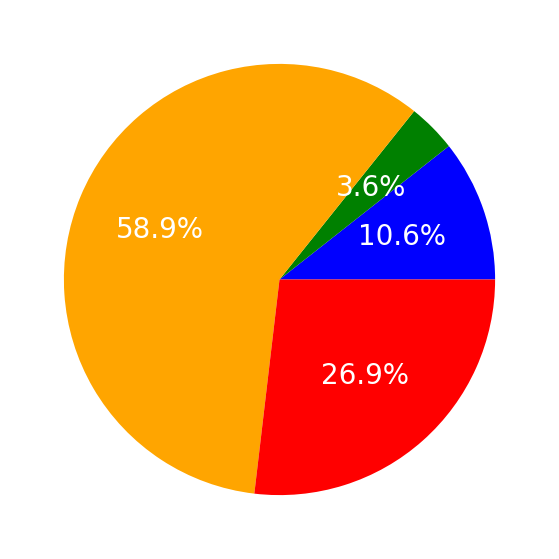

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [36]:
# Creating dataset
pathways = ['Stable', 'Recovery', 'Gradual',
        'Abrupt']

data = [len(matched_stable), len(matched_recovery), len(matched_gradual), len(matched_abrupt)]

# colors = [sns.color_palette("pastel")[0], sns.color_palette("pastel")[2], sns.color_palette("pastel")[1], sns.color_palette("pastel")[3]]
colors = ["blue", "green", "orange", "red"]
# Creating plot
fig = plt.figure(figsize=(10, 7))
plt.pie(data, colors = colors, textprops={'fontsize': 20,'color': 'white'}, autopct='%.1f%%');
# labels=pathways,
values = pd.Series([False, False, True, True])
v_counts = values.value_counts()
fig = plt.figure()
# show plot
plt.show()
plt.savefig('/home/jovyan/sara_typrin/ndvi_landsat/figures/pie_chart.png')

## Compile four category dfs into one df: 

In [37]:
data = [
    ('abrupt', matched_abrupt.elevation),
    ('gradual', matched_gradual.elevation),
    ('recovery', recovery_list),
    ('stable', matched_stable.elevation),
]
#data

## Convert to long-format DataFrame

In [38]:
df_final = pd.concat([
    pd.DataFrame({
        'Category': label, 
        'elevation': values})
    for label, values in data
])
df_final

,Category,elevation
0,abrupt,2.722750
1,abrupt,2.253136
2,abrupt,2.918356
3,abrupt,4.085401
4,abrupt,2.294834
...,...,...
129,stable,3.021718
130,stable,2.160134
131,stable,1.762089
132,stable,2.630260


# 7. Average Elevation 

In [39]:
# Calculate the average elevation per category
avg_elevation = df_final.groupby('Category')['elevation'].mean().reset_index().round(2)
print("Average Elevation per Category:\n", avg_elevation)
avg_elevation.elevation

Average Elevation per Category:
    Category  elevation
0    abrupt       1.95
1   gradual       1.90
2  recovery       2.84
3    stable       2.26


0    1.95
1    1.90
2    2.84
3    2.26
Name: elevation, dtype: float32

### Calculate standard deviation of the mean:

In [40]:
abrupt_std = np.std(matched_abrupt.elevation)
recovery_std = np.std(matched_recovery.elevation)
gradual_std = np.std(matched_gradual.elevation)
stable_std = np.std(matched_stable.elevation)

abrupt_avg_uncertainty = abrupt_std / np.sqrt(avg_elevation.elevation[0])
recovery_avg_uncertainty =  recovery_std / np.sqrt(avg_elevation.elevation[2])
gradual_avg_uncertainty =  gradual_std / np.sqrt(avg_elevation.elevation[1])
stable_avg_uncertainty =  stable_std / np.sqrt(avg_elevation.elevation[3])

In [41]:
stable_avg_uncertainty

0.6540818

### Plot averages with error bars

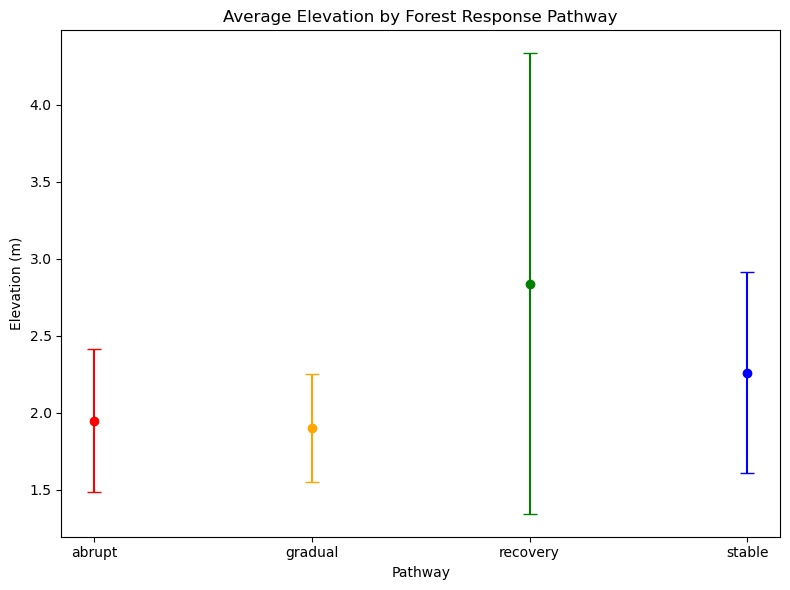

In [42]:
categories = avg_elevation['Category']
elev = avg_elevation['elevation']
errors = [abrupt_avg_uncertainty, gradual_avg_uncertainty, recovery_avg_uncertainty, stable_avg_uncertainty]
colors = ["red", "orange", "green", "blue"]

plt.figure(figsize=(8, 6))
plt.title('Average Elevation by Forest Response Pathway')
plt.xlabel('Pathway')
plt.ylabel('Elevation (m)')

for cat, el, err, col in zip(categories, elev, errors, colors):
    plt.errorbar(cat, el, yerr=err, fmt='o', color=col, ecolor=col, capsize=5)

plt.tight_layout()
plt.savefig('/home/jovyan/sara_typrin/ndvi_landsat/figures/avg_elevation')
plt.show()

# 8. ANOVA statisical analysis

In [43]:
F = stats.f_oneway(matched_gradual.elevation, matched_abrupt.elevation, matched_stable.elevation, matched_recovery.elevation, 
                   axis=0, 
                   nan_policy='propagate', 
                   keepdims=False)
F
F.statistic

## Tukey Test

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
  abrupt  gradual  -0.0455 0.7087 -0.1549   0.064  False
  abrupt recovery   0.8939    0.0  0.6289  1.1589   True
  abrupt   stable   0.3107    0.0  0.1403  0.4811   True
 gradual recovery   0.9394    0.0   0.683  1.1958   True
 gradual   stable   0.3562    0.0  0.1994  0.5129   True
recovery   stable  -0.5832    0.0 -0.8709 -0.2954   True
--------------------------------------------------------


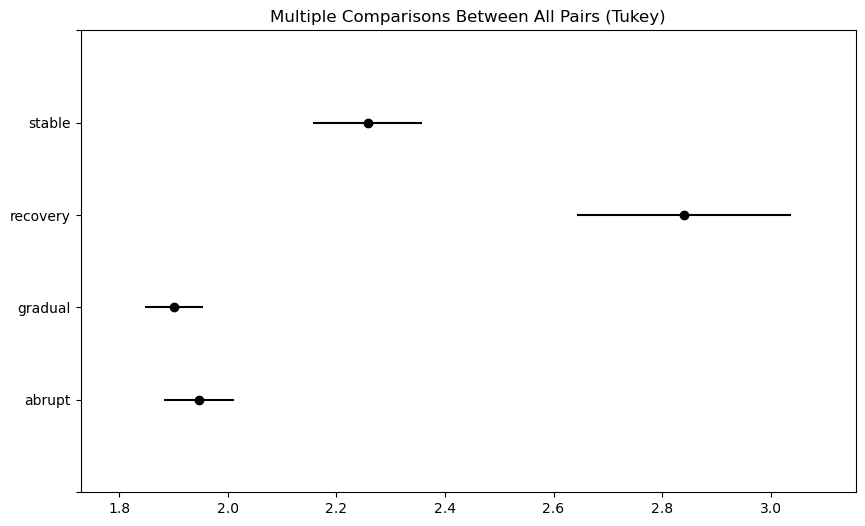

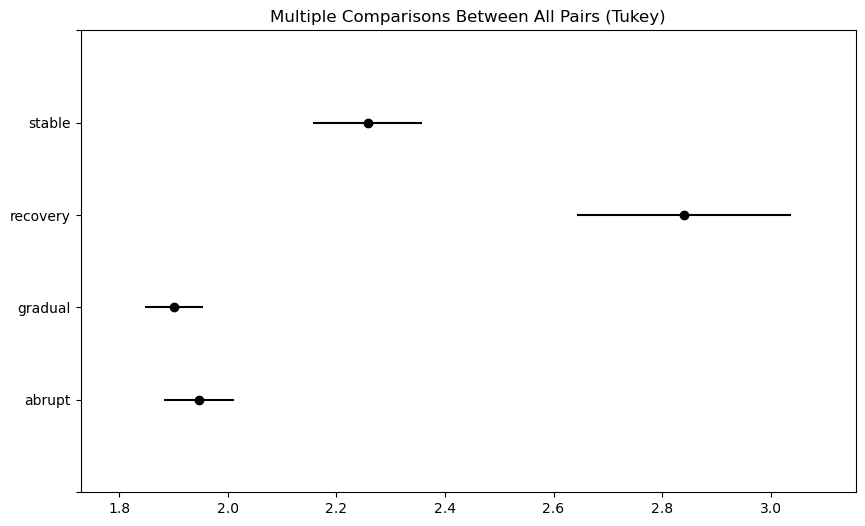

In [43]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Create a DataFrame with sample data

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(
    endog=df_final['elevation'],
    groups=df_final['Category'],
    alpha=0.05
)

# Display the results
print(tukey_results)
tukey_results.plot_simultaneous()

### T-test example

In [57]:

# group1 = matched_abrupt.elevation
# group2 = matched_gradual.elevation

# # Perform the t-test
# t_stat, p_value = stats.ttest_ind(group1, group2)

# # print("T-statistic:", t_stat)
# print("Gradual & Abrupt P-value:", p_value)

Gradual & Abrupt P-value: 0.20031453811287284


# 9. Box Plot with Means

/tmp/ipykernel_118/2766738962.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(


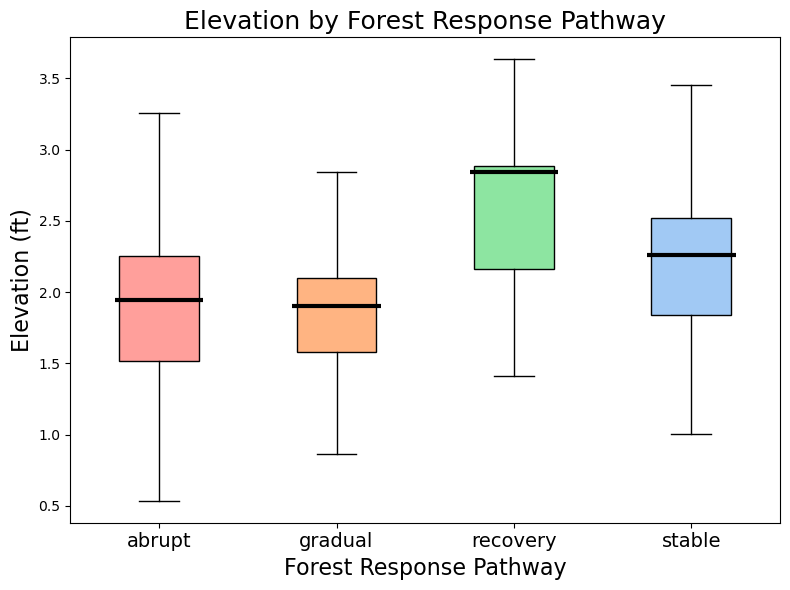

In [50]:
colors = [sns.color_palette("pastel")[3],
          sns.color_palette("pastel")[1],
          sns.color_palette("pastel")[2],
          sns.color_palette("pastel")[0]]

plt.figure(figsize=(8, 6))
plt.title('Elevation by Forest Response Pathway', fontsize=18)
plt.xlabel('Forest Response Pathway', fontsize=16)
plt.ylabel('Elevation (ft)', fontsize=16)
plt.xticks(fontsize=14)

# Prepare data
categories = df_final['Category'].unique()
data = [df_final.loc[df_final['Category'] == cat, 'elevation'] for cat in categories]

# Plot boxplot without median line or mean marker
bp = plt.boxplot(
    data,
    labels=categories,
    notch=False,
    patch_artist=True, 
    medianprops=dict(linestyle=''),  # Remove median line
    showfliers=False,
    showmeans=False,                 # We'll add custom mean lines
)

# Color each box
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

# Add bold mean lines manually
for i, group_data in enumerate(data, start=1):
    mean_val = group_data.mean()
    plt.hlines(mean_val, i - 0.25, i + 0.25, colors='black', linewidth=3)  # Bold horizontal mean line

plt.tight_layout()
plt.show()